In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import jaro


## Importing dataset

In [55]:
df = pd.read_csv("DataSF_Restaurant_Inspections.csv", low_memory=False)
print(df.head())

  business_id          business_name              business_address  \
0          19  Nrgize Lifestyle Cafe  1200 Van Ness Ave, 3rd Floor   
1          19  Nrgize Lifestyle Cafe  1200 Van Ness Ave, 3rd Floor   
2          19  Nrgize Lifestyle Cafe  1200 Van Ness Ave, 3rd Floor   
3          19  Nrgize Lifestyle Cafe  1200 Van Ness Ave, 3rd Floor   
4          19  Nrgize Lifestyle Cafe  1200 Van Ness Ave, 3rd Floor   

  business_city business_state business_postal_code  business_latitude  \
0            SF             CA                94109          37.786848   
1            SF             CA                94109          37.786848   
2            SF             CA                94109          37.786848   
3            SF             CA                94109          37.786848   
4            SF             CA                94109          37.786848   

   business_longitude         business_location business_phone_number  \
0         -122.421547  (37.786848, -122.421547)              

## Statistical analysis

In [56]:
count_not_null_rows = df[df.notnull().all(axis=1)].shape[0]
print("Count of rows with all entries not null:", count_not_null_rows)

Count of rows with all entries not null: 5255


In [57]:
print(df['business_name'].describe())
print(df['business_longitude'].describe())
print(df['business_latitude'].describe())

count                   50583
unique                   5421
top       Peet's Coffee & Tea
freq                      146
Name: business_name, dtype: object
count    29641.000000
mean      -122.213891
std          4.467835
min       -201.419639
25%       -122.437657
50%       -122.419505
75%       -122.408204
max          0.000000
Name: business_longitude, dtype: float64
count    29641.000000
mean        37.739982
std          2.169522
min          0.000000
25%         37.755177
50%         37.780298
75%         37.789563
max        340.076248
Name: business_latitude, dtype: float64


In [ ]:
df["inspection_date"].describe()

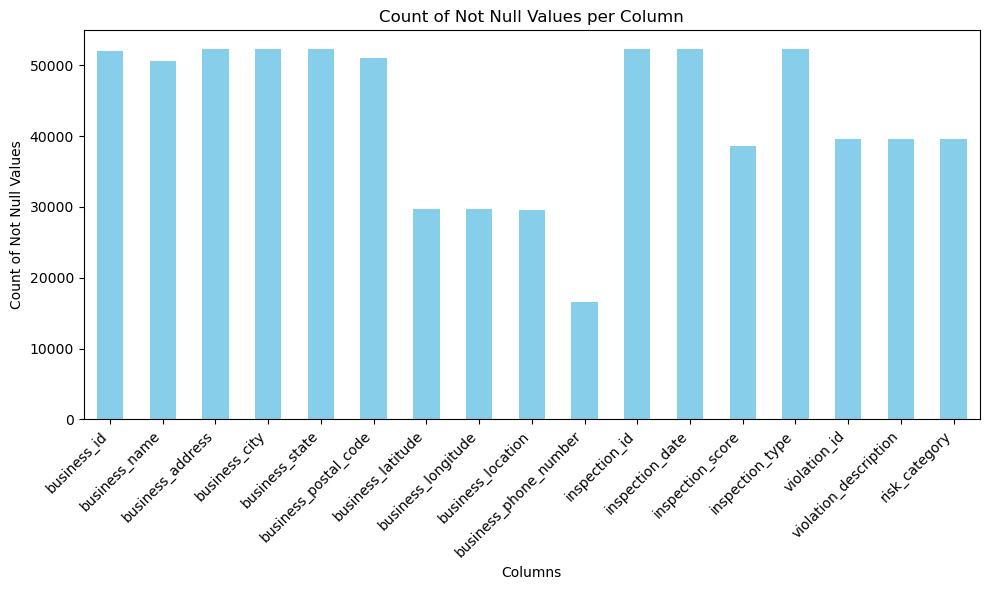

In [58]:
# Count not null values per each column
not_null_counts = df.notnull().sum()

# Plotting the histogram
plt.figure(figsize=(10, 6))
not_null_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Not Null Values per Column')
plt.xlabel('Columns')
plt.ylabel('Count of Not Null Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [75]:
df['data_quality'] = pd.NA


## Creating functions for low-quality data validation

In [106]:
print(df['business_name'].unique())

def validate_business_name(name):
    """
    Checking for valid business name
    """
    if name == "" or name == "Unavailable" or name=="hidden" or pd.isnull(name):
        return False
    return True

def validate_business_id(business_id, inspection_id):
    """
    Checking for valid business ID
    """
    if business_id == "" or (pd.isnull(business_id) and pd.isnull(inspection_id)):
        return False
    return True

def validate_business_address(address):
    """
    Checking if business address exists 
    """
    if address == "" or pd.isnull(address):
        return False
    return True

print(df['business_city'].unique())

def validate_business_city(city):
    """
    Checking if city exists     
    """
    if city == "" or pd.isnull(city):
        return False
    return True

print(df['business_state'].unique())

def validate_business_state(state):
    """
    Checking id state exists
    """
    if state == "" or pd.isnull(state):
        return False
    return True 

def validate_business_postal_code(code):
    """
    Checking for valid postal code
    """
    if pd.isnull(code):
        return False
    if len(code) == 5 and code.isdigit():
        return True
    if len(code) == 10 and code[:5].isdigit() and code[5] == '-' and code[6:].isdigit():
        return True
    return False

def validate_full_address(address, city, state, postal_code):
    """
    Validating address using previously created methods
    """
    if not validate_business_address(address):
        return False
    else:
        if not validate_business_state(state) or not validate_business_city(city):
            if not validate_business_postal_code(postal_code):
                return False
            else:
                return True
        else: 
            return True

def validate_geolocation(latitude, longitude, location):
    """
    Checking if geolocation exists and and if the location is a pair of latitude and longitude
    """
    if (pd.isna(longitude) or pd.isna(latitude)) and pd.isna(location):
        return False
    elif not pd.isna(longitude) and not pd.isna(latitude) and not pd.isna(location) and location.strip() != "("+str(latitude)+", "+str(longitude)+")":
        return False
    elif latitude==0 or longitude==0:
        return False
    else:
        return True



['Nrgize Lifestyle Cafe' 'OMNI S.F. Hotel - 2nd Floor Pantry'
 "Norman's Ice Cream and Freezes" ... 'MELMOON BAKES' 'COFFEE BAR'
 'PARIGO']
['SF' 'San Francisco' nan]
['CA' 'California' 'IL']


In [107]:
def set_data_quality_low(row):
    """
    Setting data_quality field to "low" id any of the previous validation methods failed.
    Function returns None in case a certain record passes all of the validations, 
    and needs furthes investigation to see if the record is part od high- or medium-quality data.
    """
    if not validate_business_id(row['business_id'], row['inspection_id']):
        return "low"
    elif not validate_business_name(row['business_name']):
        return "low"
    elif not validate_full_address(row['business_address'], row['business_city'],row['business_state'], row['business_postal_code']) and not validate_geolocation(row['business_latitude'], row['business_longitude'], row['business_location']):
        return "low"
    else:
        return None

# Apply the function to each row of the df

df['data_quality'] = df.apply(set_data_quality_low, axis=1)
print(df.head(50).to_string())


   business_id                       business_name               business_address business_city business_state business_postal_code  business_latitude  business_longitude         business_location business_phone_number inspection_id         inspection_date  inspection_score            inspection_type        violation_id                                                      violation_description  risk_category data_quality
0           19               Nrgize Lifestyle Cafe   1200 Van Ness Ave, 3rd Floor            SF             CA                94109          37.786848         -122.421547  (37.786848, -122.421547)                   NaN   19_20171211  12/11/2017 12:00:00 AM              94.0      Routine - Unscheduled  19_20171211_103144                           Unapproved or unmaintained equipment or utensils       Low Risk         None
1           19               Nrgize Lifestyle Cafe   1200 Van Ness Ave, 3rd Floor            SF             CA                94109          37.786848

In [108]:
na_count = df['data_quality'].isna().sum()
print("Number of records with NaN in data_quality column:", na_count)

Number of records with NaN in data_quality column: 50499


## Creating a mapping of state names and their abbreviations

In [135]:
state_codes = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}



## Creating methods to check if geolocation matches the address, and vice versa

In [164]:
def geocode_address(address):
    """
    Geocodes the given address using Nominatim API and returns the latitude and longitude.
    """
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": address,
        "format": "json",
        "limit": 1
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Ako je statusni kod izvan 200-299, baca se izuzetak
        data = response.json()


        if data:
            result = data[0]
            latitude = float(result["lat"])
            longitude = float(result["lon"])
            return latitude, longitude
        else:
            print("No results found for the address.")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error occurred during geocoding: {e}")
        return None

def reverse_geocode(latitude, longitude):
    """
    Reverse geocodes the given latitude and longitude using Nominatim API and returns the address.
    """
    base_url = "https://nominatim.openstreetmap.org/reverse"
    params = {
        "lat": latitude,
        "lon": longitude,
        "format": "json"
    }


    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Ako je statusni kod izvan 200-299, baca se izuzetak
        data = response.json()


        if 'address' in data:
            address_data = data['address']
            house_number = address_data.get('house_number', '')
            road = address_data.get('road', '')
            city = address_data.get('city', '')
            state = address_data.get('state', '')
            postcode = address_data.get('postcode', '')
            address = f"{house_number} {road}, {city}, {state}, {postcode}"
            return address
        else:
            print("No address found for the coordinates.")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error occurred during reverse geocoding: {e}")
        return None


# Example usage:
latitude = 37.7749
longitude = -122.4194
address = reverse_geocode(latitude, longitude)
print("Address:", address)


def compare_addresses(existing_address, mapped_address):
    """
    Compare two addresses using Jaro-Winkler distance.
    """
    jaro_winkler_distance = jaro.jaro_winkler_metric(existing_address.lower(), mapped_address.lower())
    return jaro_winkler_distance


# Example usage:
existing_address = "1200 Van Ness Ave, 3rd Floor, San Francisco, CA 94109"
mapped_address = "1200 Van Ness Ave, San Francisco, CA 94109"
similarity_score = compare_addresses(existing_address, mapped_address)
print("Jaro-Winkler similarity score:", similarity_score)


Address:  South Van Ness Avenue, San Francisco, California, 94103
Jaro-Winkler similarity score: 0.8673255465708296


In [170]:
def validate_address_geolocation_matching(address, city, state, postal_code, latitude, longitude, location):
    """
    Assesing the data quality based on address and geolocation.
    Function returns None in case a certain record passes all of the validations, 
    and needs furthes investigation to see if the record is part od high- or medium-quality data.
    """
    if len(state)==2:
        state_name_full = state_codes[state]
    else:
        state_name_full = state
        
    address = address.lower().replace("st", "street")  
    
    full_address = str(address) + ", " + str(city) + ", " + str(state_name_full) + ", " + str(postal_code)
    #full_address = full_address.lower().replace("st", "street")
    if  validate_full_address(address, city, state, postal_code) and not validate_geolocation(latitude, longitude, location):
        if geocode_address(full_address):   
            mapped_latitude, mapped_longitude = geocode_address(full_address)
            if mapped_latitude and mapped_longitude:
                print("Latitude:", latitude)
                print("Longitude:", longitude)
                return "medium"
            else:
                return "low"
        else:
            return "low"
    elif not validate_full_address(address, city, state, postal_code) and validate_geolocation(latitude, longitude, location):
        mapped_address = reverse_geocode(latitude, longitude)
        if mapped_address:
            print(mapped_address)
            return "medium"
        else:
            return "low"
    else:
        mapped_address = reverse_geocode(latitude, longitude)
        if mapped_address:
            similarity_score = compare_addresses(full_address, mapped_address)
            print(mapped_address, "    ", full_address, "    ", similarity_score)
            if (similarity_score<0.8):
                return "low"
            else:
                return None
 

## Grouping data by bussines_name in order to check matching between geolocation and address. This temporary dataframe will be used to asses the data quality.

In [166]:
df.columns

Index(['business_id', 'business_name', 'business_address', 'business_city',
       'business_state', 'business_postal_code', 'business_latitude',
       'business_longitude', 'business_location', 'business_phone_number',
       'inspection_id', 'inspection_date', 'inspection_score',
       'inspection_type', 'violation_id', 'violation_description',
       'risk_category', 'data_quality'],
      dtype='object')

In [175]:
selected_columns = ['business_id', 'business_name', 'business_address', 'business_city', 'business_state', 'business_postal_code', 'business_latitude', 'business_longitude', 'business_location', 'business_phone_number', 'data_quality']
filtered_df = df[selected_columns]

filtered_df = filtered_df[filtered_df["data_quality"]!="low"]

unique_inspection_df = filtered_df.drop_duplicates(subset=['business_id'], keep='first')

unique_inspection_df.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,data_quality
0,19,Nrgize Lifestyle Cafe,"1200 Van Ness Ave, 3rd Floor",SF,CA,94109,37.786848,-122.421547,"(37.786848, -122.421547)",NaN,None
6,24,OMNI S.F. Hotel - 2nd Floor Pantry,"500 California St, 2nd Floor",SF,CA,94104,37.792888,-122.403135,"(37.792888, -122.403135)",NaN,None
10,31,Norman's Ice Cream and Freezes,2801 Leavenworth St,SF,CA,94133,37.807155,-122.419004,"(37.807155, -122.419004)",NaN,None
15,NaN,CHARLIE'S DELI CAFE,3202 FOLSOM St,SF,CA,94110,37.747114,-122.413641,"(37.747114, -122.413641)",NaN,None
312,184a,RADIO HABANA,1109 VALENCIA St,San Francisco,CA,94110,37.755124,-122.420916,"(37.755124, -122.420916)",14155827659,None


In [176]:
len(unique_inspection_df)

5890

## Setting the data quality based on matching of the address and the geolocation.

In [177]:
def set_data_quality_med(row):
    """
    Assesing the data quality using the validation methods written above.
    """
    if pd.isna(row["data_quality"]):
        return validate_address_geolocation_matching(row['business_address'], row['business_city'],row['business_state'], row['business_postal_code'], row['business_latitude'], row['business_longitude'], row['business_location'])
     

unique_inspection_df['data_quality'] = unique_inspection_df.apply(set_data_quality_med, axis=1)
print(unique_inspection_df.head(100).to_string())


1200 Van Ness Avenue, San Francisco, California, 94164      1200 van ness ave, 3rd floor, SF, California, 94109      0.77309279628744
500 California Street, San Francisco, California, 94104      500 california street, 2nd  floor, SF, California, 94104      0.8405122655122654
2801 Leavenworth Street, San Francisco, California, 90214      2801 leavenworth street, SF, California, 94133      0.856453551533643
3204;3206 Folsom Street, San Francisco, California, 90103      3202 folsom street, SF, California, 94110      0.8186476196745772
1125 Valencia Street, San Francisco, California, 94110      1109 valencia street, San Francisco, California, 94110      0.9753086419753085
1600 Holloway Avenue, San Francisco, California, 94132      750 font, bldg b blvd, San Francisco, California, 94132      0.7122174122174122
572;576 Folsom Street, San Francisco, California, 94105      299 02nd street, San Francisco, California, 94105      0.7701773309746732
572;576 Folsom Street, San Francisco, California

/var/folders/4j/hy3r4tt16tb62wv3_lq2cj4h0000gn/T/ipykernel_46738/1507429828.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_inspection_df['data_quality'] = unique_inspection_df.apply(set_data_quality_med, axis=1)


## Differentiating high- from medium-quality data

In [178]:
def validate_inspection_id(violation_id, inspection_score):
    """
    Validating that each violation_id has its corresponding inspeciton_score
    """
    return inspection_score==violation_id

def set_data_quality_med1(row):
    """
    Assesing the data quality using the validation method written above.
    """
    if pd.isna(row["data_quality"]):
        return validate_inspection_id(row['violation_id'], row['inspection_score'])
  

In [188]:
unique_inspection_df['data_quality'].fillna('high', inplace=True)

/var/folders/4j/hy3r4tt16tb62wv3_lq2cj4h0000gn/T/ipykernel_46738/4068607340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_inspection_df['data_quality'].fillna('high', inplace=True)


## Calculating pecentages

In [201]:
unique_inspection_reduced = unique_inspection_df[["business_id", "data_quality"]]

In [203]:
unique_inspection_reduced.head()

,business_id,data_quality
0,19,low
6,24,high
10,31,high
15,NaN,high
312,184a,high


In [205]:
filtered_df_reduced = filtered_df[["business_id"]]

In [206]:
filtered_df_reduced.head()

,business_id
0,19
1,19
2,19
3,19
4,19


In [207]:
result = pd.merge(filtered_df_reduced, unique_inspection_reduced, how="left", on=["business_id"])

In [208]:
result.head()

,business_id,data_quality
0,19,low
1,19,low
2,19,low
3,19,low
4,19,low


In [210]:
result["data_quality"].value_counts()


data_quality
high      21951
medium    17150
low       11398
Name: count, dtype: int64

In [212]:
df_reduced = df[["business_id", "data_quality"]]

In [213]:
df_reduced.head()

,business_id,data_quality
0,19,None
1,19,None
2,19,None
3,19,None
4,19,None


In [214]:
final = pd.concat([df_reduced, result])

In [215]:
final["data_quality"].value_counts()

data_quality
high      21951
medium    17150
low       13214
Name: count, dtype: int64

In [216]:
percentages = final['data_quality'].value_counts(normalize=True) * 100

In [217]:
print(percentages)

data_quality
high      41.959285
medium    32.782185
low       25.258530
Name: proportion, dtype: float64
